In [2]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle

Welcome to JupyROOT 6.30/06


In [3]:
channel = 7

In [4]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [5]:
PATH = f'../../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_Cs.root'
#PATH = '../Dati/21-03/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_21_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare


#noise_file = '../Dati/21-03/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_0000.root'  #File di rumore di riferimento per il canale
noise_file = f'../../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_X.root'
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [6]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [7]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 7 = 883592
#Noise ripulita su ch 7 = 220636


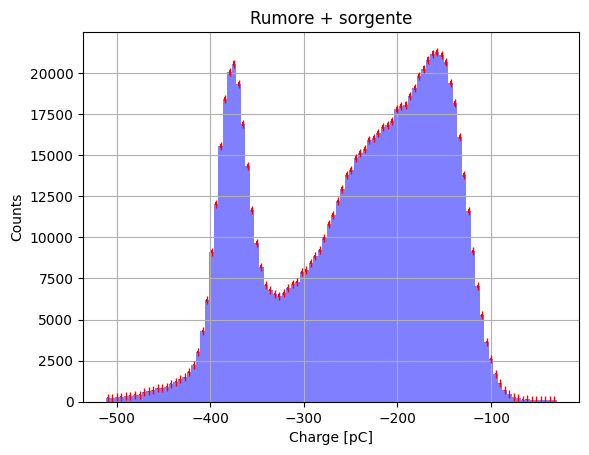

In [9]:
Nbin = 100
bin_lims = [int(Nbin * 50 / 100), int(Nbin * 100/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


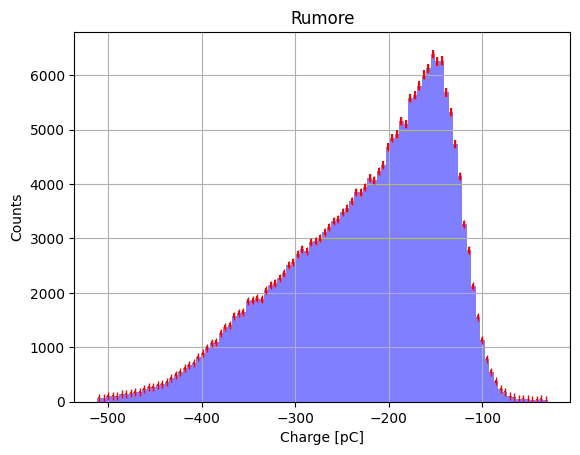

219378.0

In [10]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()


In [10]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

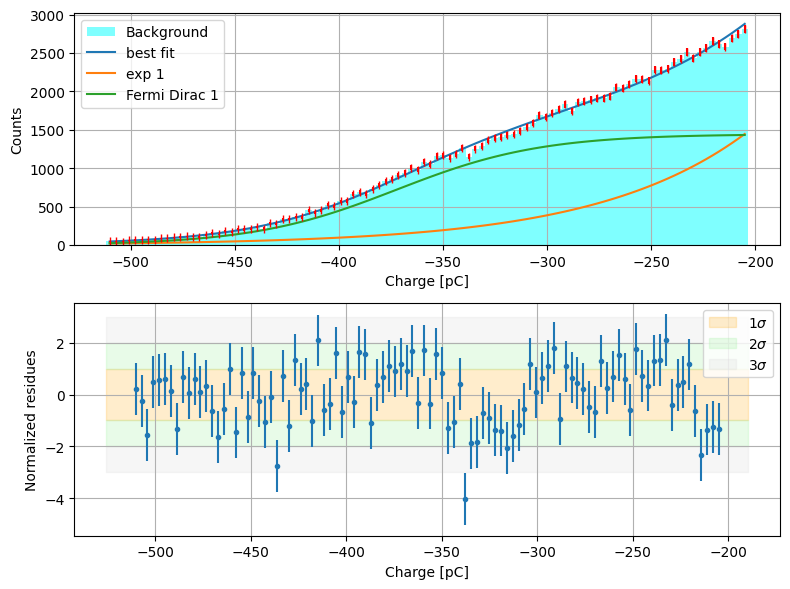

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 100
    # variables        = 5
    chi-square         = 136.688793
    reduced chi-square = 1.43882940
    Akaike info crit   = 41.2536572
    Bayesian info crit = 54.2795082
    R-squared          = 0.99999818
[[Variables]]
    e1_amplitude:  24700.9063 +/- 4162.76874 (16.85%) (init = 73755.13)
    e1_decay:     -72.2348722 +/- 5.87072924 (8.13%) (init = -76.1433)
    s1_amplitude:  1445.29051 +/- 110.497665 (7.65%) (init = 2766)
    s1_center:    -372.187801 +/- 2.49096868 (0.67%) (init = -357.5535)
    s1_sigma:      34.6065703 +/- 1.94105321 (5.61%) (init = 43.59467)
    g1_amplitude:  0 (fixed)
    g1_center:    -320 (fixed)
    g1_sigma:      25 (fixed)
    g1_fwhm:       58.8705000 +/- 0.00000000 (0.00%

In [11]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(binN, x=centersN))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   #Indovina i parametri della prima gaussiana
#params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt = -15))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))

params["g1_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g1_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g1_sigma"].vary = False
params["s2_amplitude"].vary = False
params["s2_center"].vary = False
params["s2_sigma"].vary = False

model = exp1 + gauss1 + sigmoid1 + sigmoid2  #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='Fermi Dirac 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [12]:
N_params = result.params
params.update(N_params)
params

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,24700.9063,4162.76874,(16.85%),73755.1290340094,-inf,inf,True,
e1_decay,-72.2348722,5.87072924,(8.13%),-76.14329787685425,-inf,inf,True,
s1_amplitude,1445.29051,110.497665,(7.65%),2766.0,-inf,inf,True,
s1_center,-372.187801,2.49096868,(0.67%),-357.55345153808594,-inf,inf,True,
s1_sigma,34.6065703,1.94105321,(5.61%),43.59466988699777,0.00000000,inf,True,
g1_amplitude,0.00000000,0.00000000,,0.0,-inf,inf,False,
g1_center,-320.000000,0.00000000,(0.00%),-320.0,-inf,inf,False,
g1_sigma,25.0000000,0.00000000,(0.00%),25.0,0.00000000,inf,False,
g1_fwhm,58.8705000,0.00000000,(0.00%),58.87050000000001,-inf,inf,False,2.3548200*g1_sigma
g1_height,0.00000000,0.00000000,,0.0,-inf,inf,False,"0.3989423*g1_amplitude/max(1e-15, g1_sigma)"


In [13]:
N_comp_ratio = float(params["e1_amplitude"].value / params["s1_amplitude"].value)
print(N_comp_ratio)

17.09061684425139


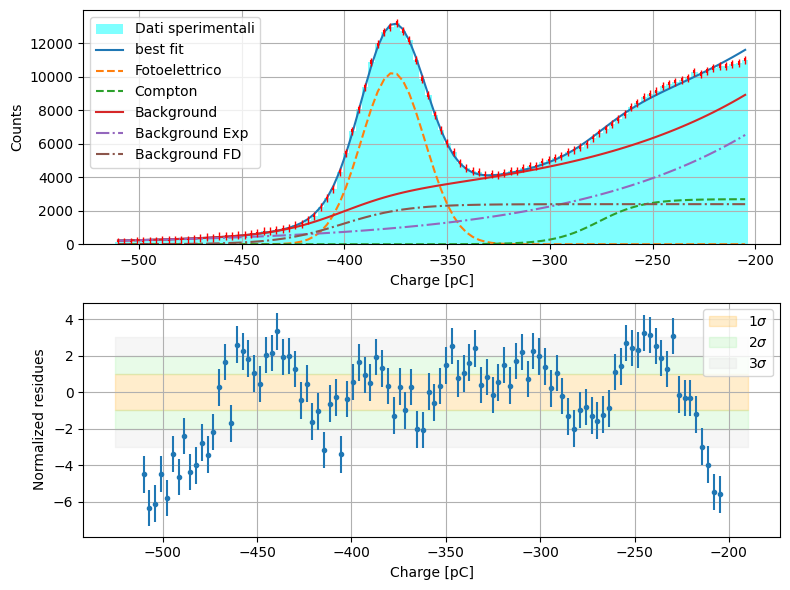

In [18]:
params.update(N_params)

params["s1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["s2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["s2_center"].vary = True
params["s2_sigma"].vary = True
params["g1_amplitude"].vary = True
params["g1_center"].vary = True
params["g1_sigma"].vary = True

params.add("ratio", value = N_comp_ratio)
params["ratio"].vary = False
#params.add("e1_amplitude", expr = 's1_amplitude * ratio')
#params["e1_amplitude"].expr = 's1_amplitude * ratio'
params["e1_amplitude"].vary = False

params["s1_amplitude"].value = 10

params["g1_amplitude"].value = 425000    #Parametri da aggiustare to make the magic happen
params["g1_center"].min = -400          #Si possono, se serve, specificare canale per canale
params["g1_center"].max = -300
params["g1_center"].set(value = -375)
params["g1_sigma"].set(value = 15)

params["s2_amplitude"].set(value = 5000)
params["s2_center"].set(value = -230)
params["s2_sigma"].set(value = 5)
params["s2_center"].min = -300
params["s2_center"].max = -100

params.update(params)

with open("../../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

noise_params = noise_params[channel]

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)

params["s1_sigma"].vary = True   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = True  #lasciando libere le ampiezze
params["e1_decay"].vary = False
params["ratio"].vary = False
params["e1_amplitude"].vary = True
params["s1_amplitude"].vary = True
params["ratio"].expr = ""

params["s1_amplitude"].vary = True
params["e1_amplitude"].vary = True
params["e1_amplitude"].value = 54057.2496
params["e1_amplitude"].expr = "ratio * s1_amplitude"

params.update(params)

# Fit the model to the data
result = model.fit(binCs, params, x = centersCs, weights = 1 / errCs)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, result.best_fit, label='best fit')
ax1.plot(centersCs, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centersCs, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centersCs, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centersCs, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centersCs, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueCs = binCs - result.best_fit
norm_resCs = residueCs / errCs

ax2.errorbar(centersCs, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [15]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 231
    # data points      = 100
    # variables        = 8
    chi-square         = 555.177713
    reduced chi-square = 6.03454036
    Akaike info crit   = 187.411808
    Bayesian info crit = 208.253170
    R-squared          = 0.99999966
[[Variables]]
    e1_amplitude:  64656.1284 +/- 995.383662 (1.54%) == 'ratio * s1_amplitude'
    e1_decay:     -89.37712 (fixed)
    s1_amplitude:  2392.13533 +/- 36.8270184 (1.54%) (init = 326.861)
    s1_center:    -400.832 (fixed)
    s1_sigma:      15.8860472 +/- 0.75069443 (4.73%) (init = 24.04369)
    g1_amplitude:  396700.372 +/- 5217.67611 (1.32%) (init = 425000)
    g1_center:    -376.302755 +/- 0.16341119 (0.04%) (init = -375)
    g1_sigma:      15.4477950 +/- 0.15898464 (1.03%) (init = 15)
  

<Figure size 640x480 with 0 Axes>

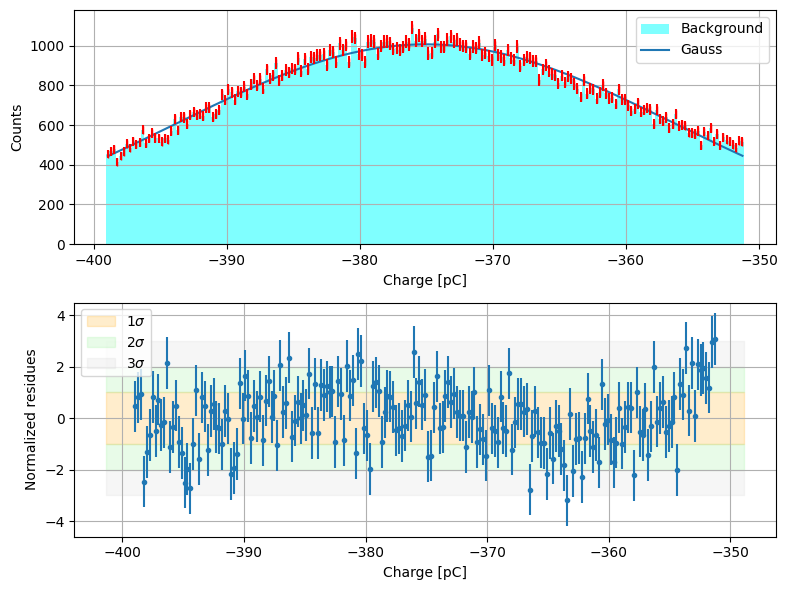

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 201
    # variables        = 3
    chi-square         = 290.823611
    reduced chi-square = 1.46880611
    Akaike info crit   = 80.2518172
    Bayesian info crit = 90.1617320
    R-squared          = 0.99995614
[[Variables]]
    g3_amplitude:  47029.1761 +/- 230.623374 (0.49%) (init = 30175.82)
    g3_center:    -375.060781 +/- 0.08572443 (0.02%) (init = -375.7868)
    g3_sigma:      18.6427502 +/- 0.12780695 (0.69%) (init = 14.90164)
    g3_fwhm:       43.9003203 +/- 0.30096236 (0.69%) == '2.3548200*g3_sigma'
    g3_height:     1006.39272 +/- 4.31451504 (0.43%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma) = +0.7833


In [16]:
Nbin_gauss = 201
bin_lims_gauss = [int(Nbin_gauss * 61.7 / 100), int(Nbin_gauss * 67/ 100)] #Scelgo gli estremi
_, edges_g, _ = plt.hist(chargeCs, bins = Nbin_gauss, color = "r")
plt.clf()
lims_gauss = [edges_g[bin_lims_gauss[0]], edges_g[bin_lims_gauss[1]]]
binCs_gauss, edgesCs_gauss, _ = plt.hist(chargeCs, bins = Nbin_gauss, range = lims_gauss, color = "b", alpha = 0.5)
centersCs_gauss = np.convolve(edgesCs_gauss, [0.5, 0.5], "valid")
errCs_gauss = np.sqrt(binCs_gauss)
plt.clf()

gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(binCs_gauss, x=centersCs_gauss)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

# Fit the model to the data
result2 = model2.fit(binCs_gauss, params2, x = centersCs_gauss, weights = 1 / errCs_gauss, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin_gauss, range = lims_gauss, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs_gauss, comps['g3_'], label='Gauss')


ax1.legend()
ax1.errorbar(centersCs_gauss, binCs_gauss, errCs_gauss, color = "red", fmt='|')
ax1.grid()

residueGauss = binCs_gauss - result2.best_fit
norm_res_gauss = residueGauss / errCs_gauss

ax2.errorbar(centersCs_gauss, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result2.fit_report())